In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from sklearn.metrics import mean_squared_error

In [2]:
# dataframes creation for both training and testing datasets 
avocado_df = pd.read_csv('avocado.csv')
avocado_df["Date"] = pd.to_datetime(avocado_df["Date"])
avocado_df = avocado_df.sort_values("Date")

In [3]:
avocado_conv = avocado_df[['Date', 'AveragePrice', 'region']][avocado_df['type']=='conventional']
avocado_conv.set_index(keys="Date", inplace=True)
avocado_org = avocado_df[['Date', 'AveragePrice', 'region']][avocado_df['type']=='organic']
avocado_org.set_index(keys="Date", inplace=True)

In [4]:
avocado_conv = avocado_conv.resample('M').mean()
avocado_conv.dropna(inplace=True)
avocado_org = avocado_org.resample('M').mean()
avocado_org.dropna(inplace=True)
print(f'Conventional length: {len(avocado_conv)}')
print(f'Organic length: {len(avocado_conv)}')

Conventional length: 39
Organic length: 39


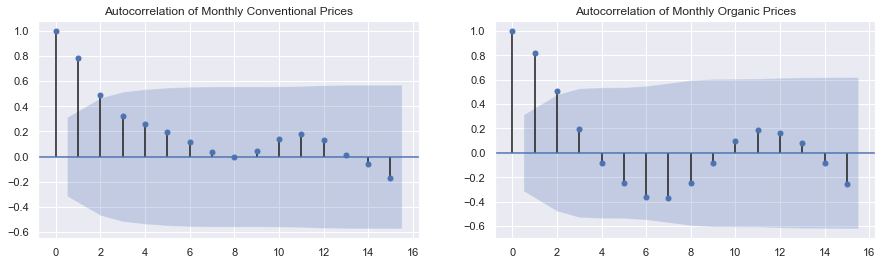

In [5]:
# Autocorrelation of prices
f, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(avocado_conv["AveragePrice"], lags=15, title="Autocorrelation of Monthly Conventional Prices", ax=axes[0])
plot_acf(avocado_org["AveragePrice"], lags=15, title="Autocorrelation of Monthly Organic Prices", ax=axes[1])
plt.show()

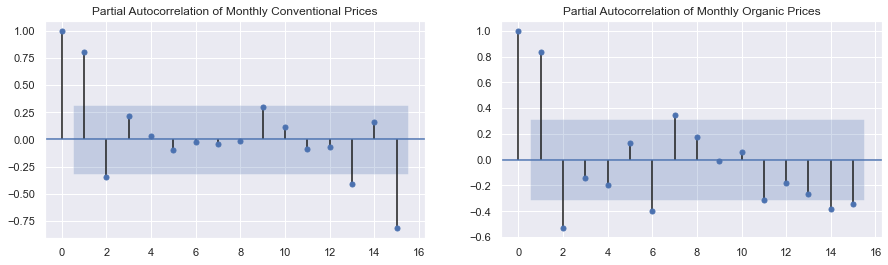

In [6]:
# Partial Autocorrelation of prices
f, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_pacf(avocado_conv["AveragePrice"], lags=15, title="Partial Autocorrelation of Monthly Conventional Prices", ax=axes[0])
plot_pacf(avocado_org["AveragePrice"], lags=15, title="Partial Autocorrelation of Monthly Organic Prices", ax=axes[1])
plt.show()

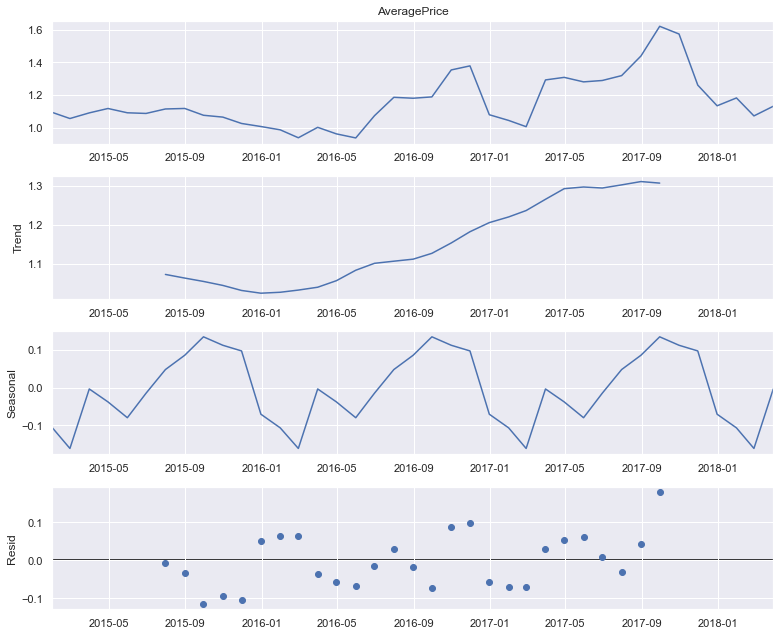

In [7]:
# Dcomposition Of Conventional Prices
y_conv = avocado_conv["AveragePrice"]#[avocado_conv["region"]=="West"]
rcParams['figure.figsize'] = 11, 9
decomposed = sm.tsa.seasonal_decompose(y_conv,)# period=2880) # The frequncy is annual
figure = decomposed.plot()
plt.show()

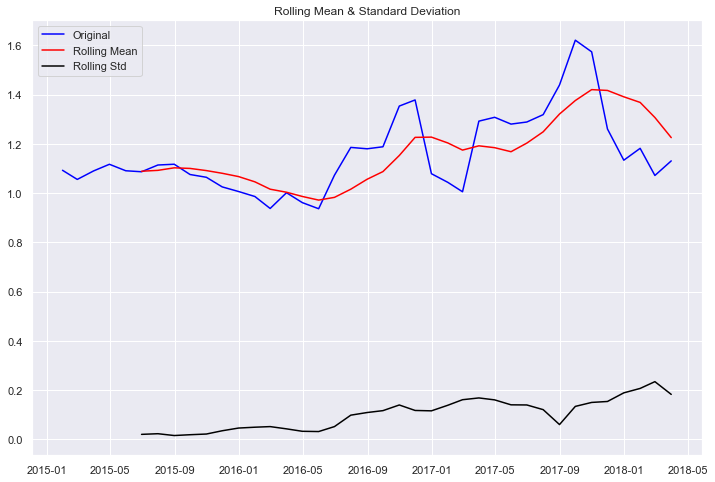

Results of Dickey-Fuller Test:
Test Statistic                 -5.125961
p-value                         0.000012
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [8]:
# Plot rolling mean and standard deviation and perform Dickey-Fuller Test on differences to make the series stationary
conv_rolling = pd.DataFrame(columns=["mean","std"])
conv_rolling["mean"] = y_conv.rolling(6).mean()
conv_rolling["std"] = y_conv.rolling(6).std()

# Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(y_conv, color='blue',label='Original')
mean = plt.plot(conv_rolling["mean"], color='red', label='Rolling Mean')
std = plt.plot(conv_rolling["std"], color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

print('Results of Dickey-Fuller Test:')
dftest = adfuller(y_conv.diff().iloc[1:], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Good! The p value is small.

The root mean squared error is 0.194.


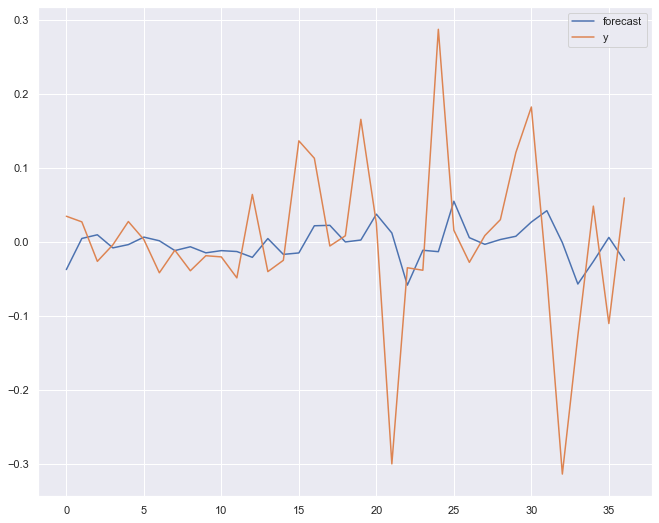

In [9]:
# Try ARIMA models
AR = ARIMA(y_conv.diff().iloc[1:].values, order=(1,1,1))
res = AR.fit()
start = 1
duration = 36
rmse = math.sqrt(mean_squared_error(avocado_conv["AveragePrice"].diff().iloc[start:start+duration].values, 
                                    res.predict(start=start,end=start+duration-1)))
print(f"The root mean squared error is {rmse:.3}.")

res.plot_predict(start=start, end=start+duration)
plt.show()

Very far from actual values and no seasonality

In [10]:
# Try SARIMA models
SAR = SARIMAX(y_conv.diff().iloc[1:].values, order=(0,1,1),seasonal_order=(1,1,0,12))
model = SAR.fit()

The root mean squared error is 0.0903. 

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   38
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                  13.975
Date:                             Thu, 30 Apr 2020   AIC                            -21.950
Time:                                     03:05:33   BIC                            -18.293
Sample:                                          0   HQIC                           -20.935
                                              - 38                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9464      0.501     -1.889      0.059      -1.92

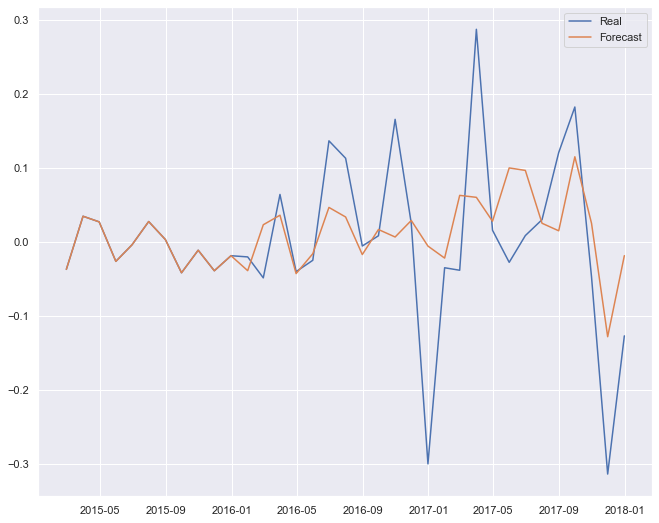

In [11]:
start = 1
duration = 36
results = model.predict(start=start,end=start+duration-1)
rmse = math.sqrt(mean_squared_error(
    y_conv.diff().iloc[start:start+duration-1].values, 
    results[:-1]))
print(f"The root mean squared error is {rmse:.3}. \n")

print(model.summary())

plt.plot(y_conv.iloc[start:start+duration-1].index, y_conv.diff().iloc[start:start+duration-1].values)
plt.plot(y_conv.iloc[start:start+duration-1].index, results[:-1])
plt.legend(['Real','Forecast'])
plt.show()

Not perfect, but much better than the ARIMA models, Let's try to forecast for the next two years

In [12]:
a = model.get_forecast(23)

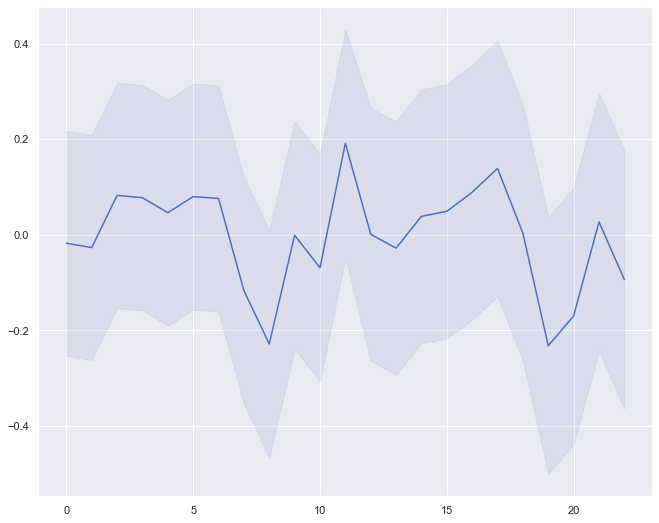

In [13]:
# plot mean and confidence interval
plt.plot(a.predicted_mean)
plt.fill_between(x=np.arange(23),y1=a.conf_int()[:,0],y2=a.conf_int()[:,1], color='b', alpha=.1)
plt.show()

In [14]:
# prepare future dates
fut_dates = pd.date_range(start='4/1/2018', periods=23, freq='M')
fut_dates = y_conv.index.append(fut_dates)

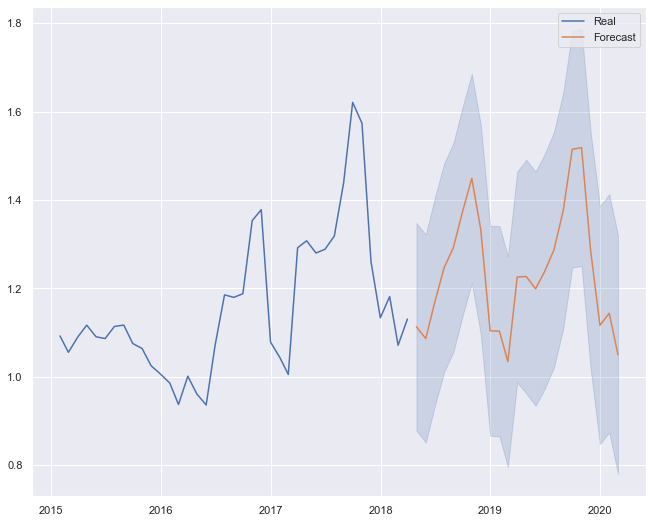

In [15]:
# change from difference to actual prices and plot mean and confidence interval
plt.plot(y_conv.iloc[:40].index, y_conv.iloc[:40].values)
plt.plot(fut_dates[39:],  avocado_conv.iloc[-1].values + np.cumsum(a.predicted_mean))
plt.fill_between(fut_dates[39:],
                 y1=a.conf_int()[:,0] - a.predicted_mean + avocado_conv.iloc[-1].values + np.cumsum(a.predicted_mean),
                 y2=a.conf_int()[:,1] - a.predicted_mean + avocado_conv.iloc[-1].values + np.cumsum(a.predicted_mean),
                 color='b', alpha=.2)
plt.legend(["Real","Forecast"])
plt.show()

The seasonality is well captured, especially for the tops and bottoms.